# Lab - Parallel Computing Part 4 - CUDA Classifier Inference
## E6692 Spring 2022


In this part we implement a basic CNN classifier that uses the layers we defined in Part 1 to complete a forward pass. We transfer the weights from the trained **PyTorchClassifier** to **CUDAClassifier** to perform inference.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision

from utils.models import CUDAClassifier, PyTorchClassifier
from utils.dataset import load_mnist_dataset, display_image, BATCH_SIZE

# define kernel path
kernel_path = './kernels.cu'

%load_ext autoreload
%autoreload 2

%matplotlib inline

TODO: Implement the functions **CUDAClassifier.load_state_dict()** and **CUDAClassifier.forward()** in **utils/models.py**.

In the following cell we read the PyTorch saved weights:

In [2]:
state_dict_path = './models/MNIST classification' # define weights path
state_dict = torch.load(state_dict_path)


TODO: Create an instance of CUDAClassifier and use the **load_state_dict()** function to load the saved weights from **PyTorchClassifier** that were trained in Part 3. 

In [3]:
# TODO: load the trained weights with CUDAClassifier.load_state_dict()

cuda_model = CUDAClassifier(kernel_path)
cuda_model.load_state_dict(torch.load(state_dict_path))

In [4]:
################################################################
######## CUDAClassifier.load_state_dict() TEST CASES ###########
################################################################

pytorch_model = PyTorchClassifier()
pytorch_model.load_state_dict(torch.load(state_dict_path))
pytorch_state_dict = pytorch_model.state_dict()
pytorch_weight_keys = pytorch_state_dict.keys()
cuda_state_dict = cuda_model.state_dict
cuda_model_keys = cuda_state_dict.keys()

print("All CUDA model and PyTorch model keys match: ", pytorch_weight_keys == cuda_model_keys )

passing = True
for key, cuda_weight in cuda_state_dict.items():
    if not np.allclose(pytorch_state_dict[key].numpy(), cuda_weight):
        passing = False
        break

print("All CUDA model and PyTorch model weights match: ", passing)

################################################################
################ DO NOT MODIFY THE CODE ABOVE ##################
################################################################

All CUDA model and PyTorch model keys match:  True
All CUDA model and PyTorch model weights match:  True


/usr/local/lib/python3.6/dist-packages/torchvision-0.10.0a0+300a8a4-py3.6-linux-aarch64.egg/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /media/nvidia/NVME/pytorch/pytorch-v1.9.0/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


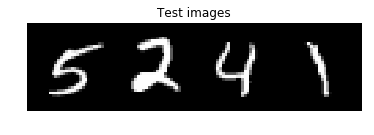

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /media/nvidia/NVME/pytorch/pytorch-v1.9.0/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


CUDAClassifier.forward() Test Case 1 Passed:  True
CUDA model prediction:  5
PyTorch model prediction:  5

CUDAClassifier.forward() Test Case 2 Passed:  True
CUDA model prediction:  2
PyTorch model prediction:  2

CUDAClassifier.forward() Test Case 3 Passed:  True
CUDA model prediction:  4
PyTorch model prediction:  4

CUDAClassifier.forward() Test Case 4 Passed:  True
CUDA model prediction:  3
PyTorch model prediction:  3



In [5]:
################################################################
############ CUDAClassifier.forward() TEST CASES ###############
################################################################

_, val_set = load_mnist_dataset()

sample_images, sample_labels = iter(val_set).next()
sample_images_grid = torchvision.utils.make_grid(sample_images)
display_image(sample_images_grid, title="Test images")

for i in range(BATCH_SIZE):
    
    x = np.transpose(sample_images[i], (1, 2, 0)).numpy()
    cuda_x = cuda_model(x)
    cuda_prediction = np.argmax(cuda_x)
    torch_x = pytorch_model(sample_images[i].unsqueeze(dim=0)).detach().squeeze(dim=0).squeeze(dim=0).numpy()
    torch_prediction = np.argmax(torch_x)
    
    print("CUDAClassifier.forward() Test Case {} Passed: ".format(i + 1), np.allclose(cuda_x, torch_x))
    print("CUDA model prediction: ", cuda_prediction)
    print("PyTorch model prediction: ", torch_prediction)
    print()
    
################################################################
################ DO NOT MODIFY THE CODE ABOVE ##################
################################################################

### Discussion

#### 1. Why is a transfer of trained parameters between different types of models with the same structure useful?

TODO: your answer here.

Because we are using different kinds of implementations and we don't know which is better and suitable for the device. If the device can't use pytorch or not powerful enough for taining. Then we can train the model on much powerful machines and transfer it to the device using the suitable framework.

#### 2. What would happen if we tried to train CUDAClassifier directly? Would it be able to train successfully? In either case, explain your reasoning.

TODO: your answer here.

We can't train CUDAClassifier directly, because there's no back propagation in the function we write. To train the model, we need to calculate the gradient and use BP to adjust the parameters. The pytorch framework use the computational graph method so that it can back propagate the parameters. 

#### 3. If you answered yes (CUDAClassifier would successfully train) for 2, what about its implementation allows this to be possible? If you answered no (CUDAClassifier cannot successfully train) for 2, what needs to happen to make training possible?

TODO: your answer here.

We need to:

First, add gradient to the layer functions. Like, having an error between the output and label, then compute the gradient of parameters.

Second, add training functions that update the parameters with the calculated gradient for each layer using some kind of optimization method.

#### 4. Insert your favorite ML/AI/GPU hardware Meme 

TODO: Your meme here.

lol

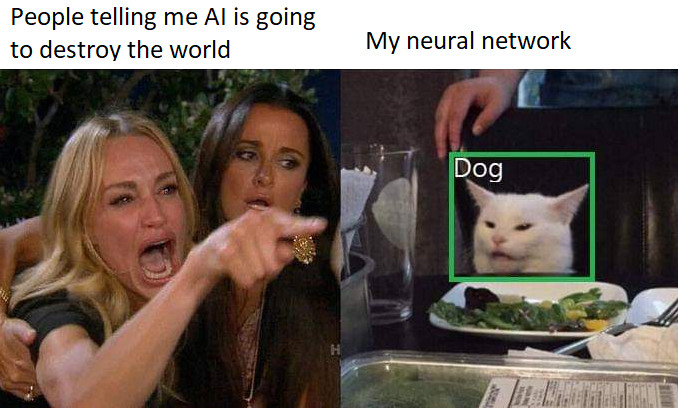

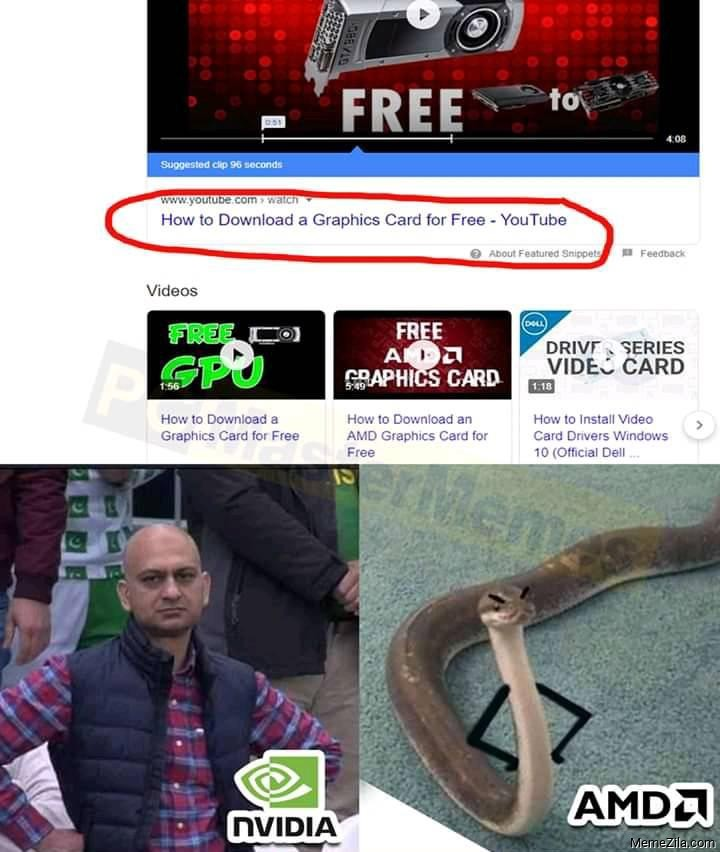